In [1]:
import time
import copy
import torch
import torchvision
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from torch.utils.data import Dataset
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
PATH_OF_SIDE = "/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera1"
PATH_OF_FRONT = "/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera2"

print(PATH_OF_SIDE)
print(PATH_OF_FRONT)

/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera1
/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera2


In [17]:
full_data_set_side = torchvision.datasets.ImageFolder(root = PATH_OF_SIDE)
full_data_set_front = torchvision.datasets.ImageFolder(root = PATH_OF_FRONT)

classes = full_data_set_side.classes
print(classes)

['Bottom', 'Center Stack', 'Instrument Cluster', 'Left', 'Rearview Mirror', 'Right', 'Road']


In [18]:
data_transforms = {
    "train":
        torchvision.transforms.Compose([
                    torchvision.transforms.Resize((224, 224)),
# # #                     torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    "val":
        torchvision.transforms.Compose([ 
                    torchvision.transforms.Resize((224, 224)),
# #                     torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    "test":
        torchvision.transforms.Compose([ 
                    torchvision.transforms.Resize((224, 224)),
#                     torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
}

In [19]:
print('Total number of images: ', len(full_data_set_side))
print('Total number of images: ', len(full_data_set_front))

Total number of images:  9882
Total number of images:  9882


In [20]:
class CustomDataset(torchvision.datasets.ImageFolder):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [21]:
from torch.utils.data import Subset 
from torch._utils import _accumulate
from torch import randperm

def custom_random_split(dataset_first, dataset_second, lengths):
    if sum(lengths) != len(dataset_first):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths)).tolist()
    return [Subset(dataset_first, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)], [Subset(dataset_second, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [22]:
VALIDATION_FRACTION = 1/10
TRAIN_FRACTION = 4/5

train_size = int(TRAIN_FRACTION * len(full_data_set_side))
val_size = int(VALIDATION_FRACTION * len(full_data_set_side))
test_size = len(full_data_set_side) - train_size - val_size

# train_subset_side, val_subset_side, test_subset_side, train_subset_front, val_subset_front, test_subset_front = custom_random_split(full_data_set_side, full_data_set_front, [train_size, val_size, test_size])
(train_subset_side, val_subset_side, test_subset_side), (train_subset_front, val_subset_front, test_subset_front) = custom_random_split(full_data_set_side, full_data_set_front, [train_size, val_size, test_size])

In [23]:
train_dataset_side = CustomDataset(
    train_subset_side, transform=data_transforms["train"]
)
val_dataset_side = CustomDataset(
    val_subset_side, transform=data_transforms["val"]
)
test_dataset_side = CustomDataset(
    test_subset_side, transform=data_transforms["test"]
)

train_dataset_front = CustomDataset(
    train_subset_front, transform=data_transforms["train"]
)
val_dataset_front = CustomDataset(
    val_subset_front, transform=data_transforms["val"]
)
test_dataset_front = CustomDataset(
    test_subset_front, transform=data_transforms["test"]
)

In [24]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_data_loader_side = torch.utils.data.DataLoader(train_dataset_side, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

validation_data_loader_side = torch.utils.data.DataLoader(val_dataset_side, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

test_data_loader_side = torch.utils.data.DataLoader(test_dataset_side, batch_size=BATCH_SIZE, 
                                          num_workers=NUM_WORKERS)

train_data_loader_front = torch.utils.data.DataLoader(train_dataset_front, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

validation_data_loader_front = torch.utils.data.DataLoader(val_dataset_front, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

test_data_loader_front = torch.utils.data.DataLoader(test_dataset_front, batch_size=BATCH_SIZE, 
                                          num_workers=NUM_WORKERS)

In [25]:
dataloaders_side = {
    'train': train_data_loader_side,
    'val': validation_data_loader_side,
    'test': test_data_loader_side,
}

dataloaders_front = {
    'train': train_data_loader_front,
    'val': validation_data_loader_front,
    'test': test_data_loader_front
}

In [26]:
dataset_sizes = {
    "train": len(train_data_loader_side.dataset),
    "val": len(validation_data_loader_side.dataset),
    "test": len(test_data_loader_side.dataset)
}

print('Num training images: ', dataset_sizes["train"])
print('Num validation images: ', dataset_sizes["val"])
print('Num test images: ', dataset_sizes["test"])

Num training images:  7905
Num validation images:  988
Num test images:  989


In [27]:
dataiter_side = iter(test_data_loader_side)
images_side, labels_side = dataiter_side.next()
images_side = images_side.numpy()


dataiter_front = iter(test_data_loader_front)
images_front, labels_front = dataiter_front.next()
images_front = images_front.numpy() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

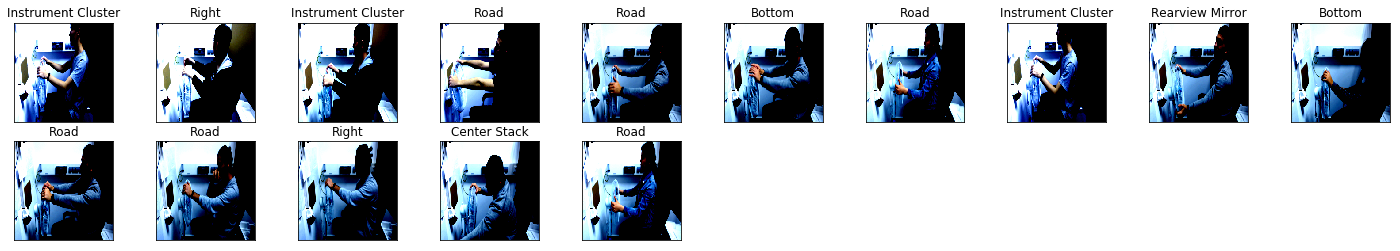

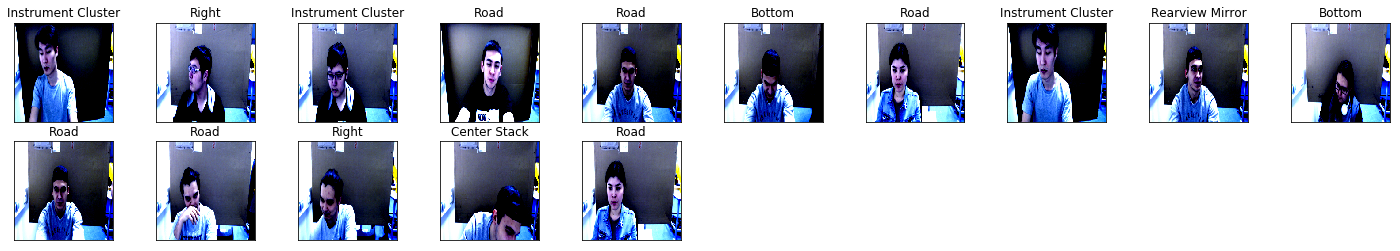

In [28]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_side[idx], (1, 2, 0))) # np transpose to convert tensor to image
    ax.set_title(classes[labels_side[idx]])


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_front[idx], (1, 2, 0))) # np transpose to convert tensor to image
    ax.set_title(classes[labels_front[idx]])

In [29]:
weight_side = torch.load('./models/resnet_posture_with_conv.pth')
weight_front = torch.load('./models/resnet_final_model_conv_freeze.pth')

In [34]:
model_side = torchvision.models.resnet50(pretrained = False)
#features_num_side = model_side.fc.in_features

# Freeze weights
for param in model_side.parameters():
    param.requires_grad = False

# ct = 0
# for child in model_side.children():
#     ct += 1
#     if ct < 7:
#         for param in child.parameters():
#             param.requires_grad = False
            
features_num_side = model_side.fc.in_features

model_side.fc = torch.nn.Sequential(
    torch.nn.Linear(features_num_side, 1024),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(512, 7)
)

model_side.load_state_dict(weight_side, strict=False)
model_side.fc = list(model_side.children())[9][:-2]

model_side.to(device)
model_side.fc

for param in model_side.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [35]:
model_front = torchvision.models.resnet50(pretrained = True)
#features_num_front = model_front.fc.in_features

# Freeze weights
for param in model_front.parameters():
    param.requires_grad = False

# ct = 0
# for child in model_front.children():
#     ct += 1
#     if ct < 7:
#         for param in child.parameters():
#             param.requires_grad = False

features_num_side = model_front.fc.in_features

model_front.fc = torch.nn.Sequential(
    torch.nn.Linear(features_num_side, 1024),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(512, 7)
)

model_front.load_state_dict(weight_front, strict=False)
model_front.fc = list(model_front.children())[9][:-2]

model_front.to(device)
model_front.fc

for param in model_front.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [39]:
class Concatenate(torch.nn.Module):
    def __init__(self, model_side, model_front):
        super(Concatenate, self).__init__()
        
        for param in model_side.parameters():
            param.requires_grad = False
        self.model_side = model_side
        
        for param in model_front.parameters():
            param.requires_grad = False
        self.model_front = model_front
        
        self.classifier = torch.nn.Sequential(
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 7)
        )
        
    def forward(self, x1, x2):
        m1 = self.model_side(x1)
        m2 = self.model_front(x2)
        x = torch.cat((m1, m2), dim = 1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x

model = Concatenate(model_side, model_front)
model

# for param in model.parameters():
#     print(param.requires_grad)

Concatenate(
  (model_side): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)

In [41]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0
            
#             counter = 0

            for input_side_list,input_front_list in zip(dataloaders_side[phase], dataloaders_front[phase]):
#                 counter += 1
                input_side, labels1 = input_side_list
                input_front, labels2 = input_front_list
                labels = labels1
                input_side = input_side.to(device)
                input_front = input_front.to(device)
                labels = labels.to(device)

                outputs = model(input_side, input_front)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * input_side.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 if (counter % 100):
#                     print ('Train: {}/{}'.format(counter * BATCH_SIZE, len(dataloaders_side[phase].dataset)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print('{} - Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './models/concat.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    results= {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }
    return model, copy.deepcopy(results)

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [43]:
model.to(device)
# model = torch.nn.DataParallel(model)

model_ft, results = train_model(model, criterion, optimizer,
                       num_epochs=50)

Epoch 0/49
----------
train - Loss: 1.8306 Acc: 0.3351
val - Loss: 1.8004 Acc: 0.3451

Epoch 1/49
----------
train - Loss: 1.7929 Acc: 0.3435
val - Loss: 1.7665 Acc: 0.3573

Epoch 2/49
----------
train - Loss: 1.7488 Acc: 0.3571
val - Loss: 1.7146 Acc: 0.3735

Epoch 3/49
----------
train - Loss: 1.6745 Acc: 0.3809
val - Loss: 1.6256 Acc: 0.4140

Epoch 4/49
----------
train - Loss: 1.5750 Acc: 0.4273
val - Loss: 1.5211 Acc: 0.4534

Epoch 5/49
----------
train - Loss: 1.4809 Acc: 0.4548
val - Loss: 1.4298 Acc: 0.4565

Epoch 6/49
----------
train - Loss: 1.4014 Acc: 0.4817
val - Loss: 1.3569 Acc: 0.4808

Epoch 7/49
----------
train - Loss: 1.3325 Acc: 0.5101
val - Loss: 1.2940 Acc: 0.5314

Epoch 8/49
----------
train - Loss: 1.2744 Acc: 0.5371
val - Loss: 1.2419 Acc: 0.5476

Epoch 9/49
----------
train - Loss: 1.2222 Acc: 0.5651
val - Loss: 1.1934 Acc: 0.5587

Epoch 10/49
----------
train - Loss: 1.1722 Acc: 0.5856
val - Loss: 1.1456 Acc: 0.5698

Epoch 11/49
----------
train - Loss: 1.122

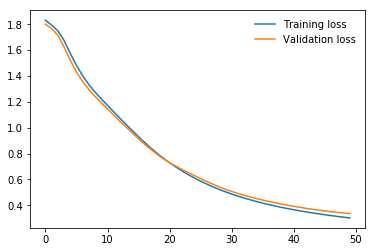

In [44]:
plt.plot(results['train_losses'], label='Training loss')
plt.plot(results['val_losses'], label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [45]:
def test(test_model):   
    criterion = torch.nn.CrossEntropyLoss()
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    test_model.to(device)
    test_model.eval()
    # iterate over test data
    for (data_side, target1), (data_front, target2) in zip(dataloaders_side['test'], dataloaders_front['test']):
        target = target1
        # move tensors to GPU if CUDA is available
        data_side, data_front, target = data_side.to(device), data_front.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = test_model(data_side, data_front)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item() * dataset_sizes['test']
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = (
                 np.squeeze(correct_tensor.cpu().numpy()))
        # calculate test accuracy for each object class
        for i in range(BATCH_SIZE):
            if (i < len(target.data)):
                label = target.data[i]
                if (label < len(class_correct)):
    #                 print(correct[i])
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

    # average test loss
    test_loss = test_loss/dataset_sizes['test']
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(7):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [46]:
test(model_ft)

Test Loss: 5.179270

Test Accuracy of Bottom: 97% (146/149)
Test Accuracy of Center Stack: 82% (82/100)
Test Accuracy of Instrument Cluster: 63% (57/90)
Test Accuracy of  Left: 86% (75/87)
Test Accuracy of Rearview Mirror: 91% (98/107)
Test Accuracy of Right: 85% (85/99)
Test Accuracy of  Road: 97% (348/357)

Test Accuracy (Overall): 90% (891/989)
